In [1]:
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import random

# from scipy.signal import convolve2d
# from scipy.ndimage import convolve

import os
import json
# from perlin_noise import perlin_noise
# from flood_fill import flood_fill

from utils import generate_grid
from utils import plot_trajectory
from utils import spawn_point

In [2]:
plt.rcParams['figure.figsize'] = (16,12)
np.random.seed(1234)

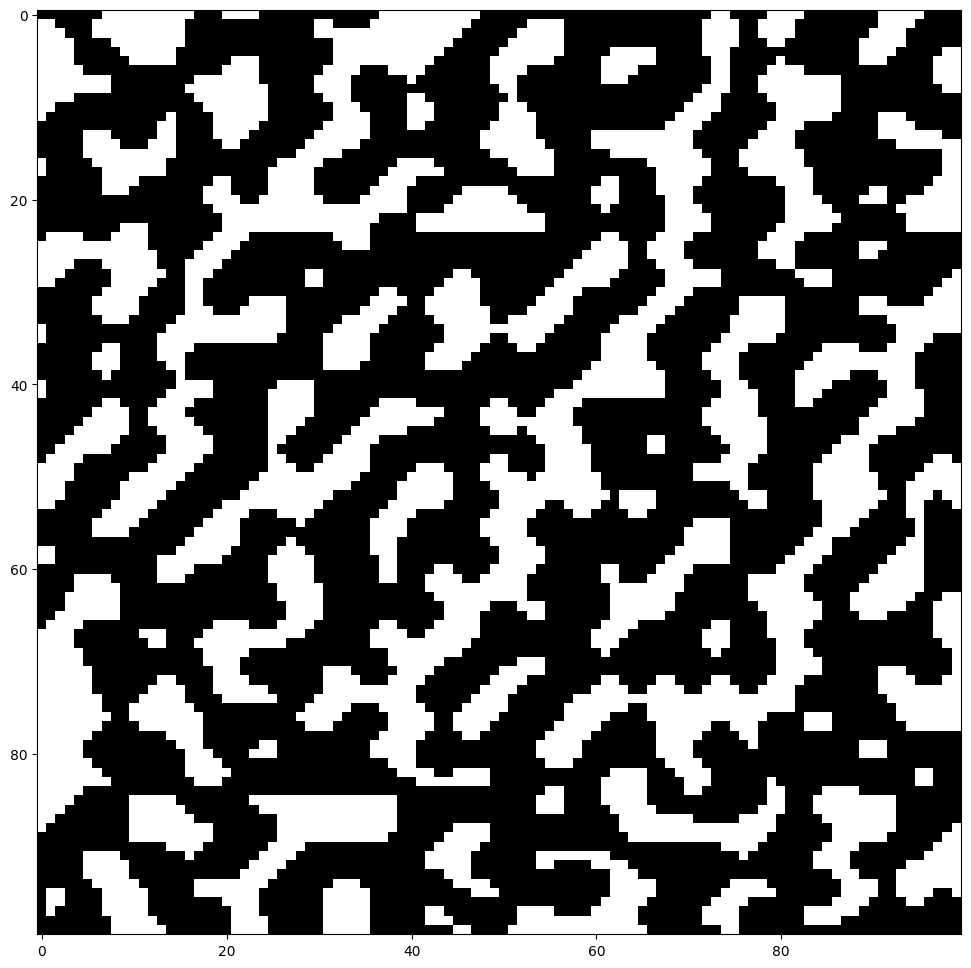

In [3]:
grid = generate_grid(100)
plt.imshow(grid, cmap='grey')
plt.show()

## Movement
 - Randomly move in direction
 - If collision
   - Return to same state
 - Else
   - Keep moving

 % Area covered 0.6876035797149487


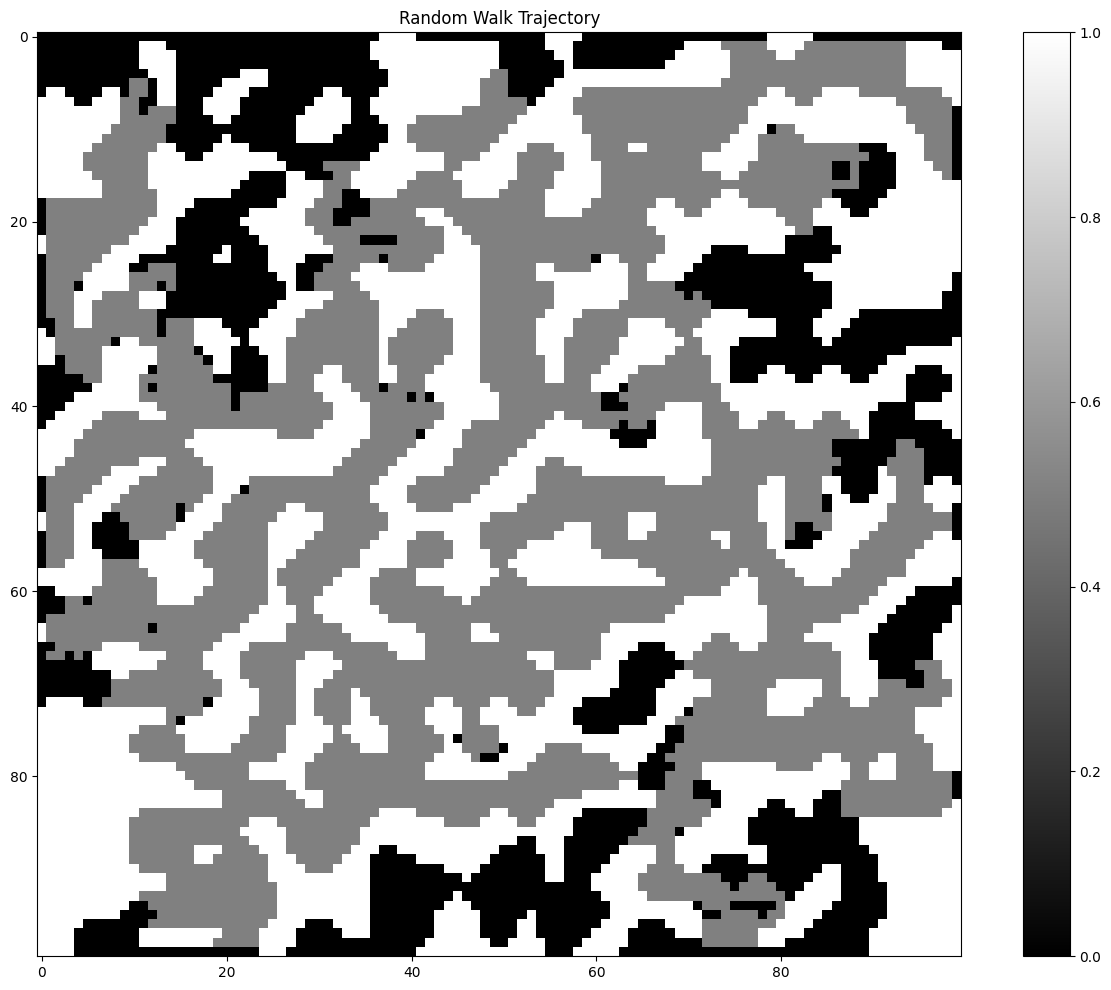

In [4]:
size = 100
grid = generate_grid(size)
height, width = size, size  # Example grid size

# Initialize starting position
current_pos = spawn_point(grid)
x,y = current_pos

# Initialize the trajectory grid and list to track the trajectory
transversed_grid = grid.copy()
trajectory = []
cells_covered = set()

# Number of steps for the random walk
steps = 100000
directions = [(0, 1), (0, -1), (-1, 0), (1, 0)]

for i in range(steps):
    # Possible directions for movement (up, down, left, right)

    # Randomly choose a direction
    move = random.choice(directions)

    # Calculate the new position
    new_pos = current_pos + move

    # Ensure the new position is within the grid boundaries
    if 0 < new_pos[0] < height-1 and 0 < new_pos[1] < width-1 and grid[tuple(new_pos)] != 1:
        current_pos = new_pos
        trajectory.append(tuple(current_pos))
        cells_covered.add(tuple(current_pos))

num_cells_covered = len(cells_covered)
empty_cells = np.count_nonzero(grid==0)
area_covered = num_cells_covered/empty_cells
for point in trajectory:
    transversed_grid[point] = 0.5

print(f' % Area covered {area_covered}')
# Display the trajectory as a heatmap
plt.imshow(transversed_grid, cmap='gray')
plt.title("Random Walk Trajectory")
plt.colorbar()
plt.show()

In [5]:
print(f' Number of empty cells {empty_cells}, number of cells covered = {len(cells_covered)}, length of trajectory = {len(trajectory)}')

 Number of empty cells 6034, number of cells covered = 4149, length of trajectory = 87150


## Visibliity
 - Agent can see 5x5 or 3x3 around them
 - Implement by slicing  grid points
 - Initialize unknow global map
 - Update map by slicing information

(100, 100, 3) (100, 100)


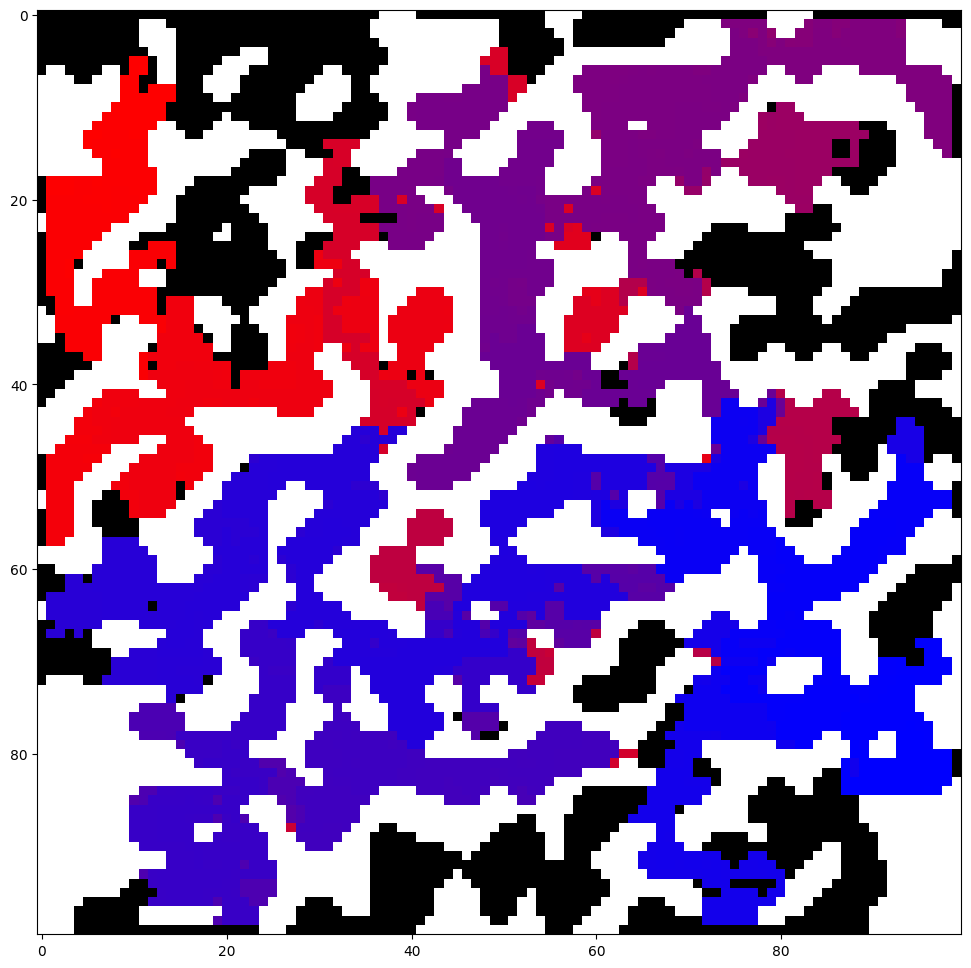

In [6]:
plot_trajectory(grid, trajectory)

In [7]:
# WHEN AT POSITION X,Y
def get_visible(grid, x,y):
    """
    Get the slice of array which is visible to the agent from position x,y
    """
    padding = ((1, 1), (1, 1))
    padded_grid = np.pad(grid, padding, mode='constant', constant_values=-1)
    visible_space = padded_grid[x:x+3, y:y+3]

    return visible_space

## Converting to RL environment
- State = visible patch, current position
- Action = move
- reward = -1
- terminal condition = Whole grid is explored 

In [8]:
class GridEnv():
    def __init__(self, size=100):
        
        self.grid = generate_grid(size)
        self.height, self.width = size, size
        self.actions = {
            "UP" : (0, 1), 
            "DOWN" : (0, -1), 
            "LEFT" : (-1, 0), 
            "RIGHT" : (1, 0),
        }
        self.trajectory = []
        self.agent_start_position = np.array((0,0))
        self.agent_position = self.agent_start_position
        self.visited_cells = set()

    def reset(self):
        self.agent_position = self.agent_start_position
        done = False
        x,y = self.agent_position
        visible_patch = get_visible(self.grid, x,y)
        state = (self.agent_position, visible_patch)
        return state, done
    
    def step(self, action):
        movement = self.actions[action]
        new_position = self.agent_position + movement
        done = False
        if 0 <= new_position[0] <= self.height-1 and 0 <= new_position[1] <= self.width-1 and self.grid[tuple(new_position)] != 1:
            self.agent_position = new_position
            new_position = tuple(new_position)
            self.trajectory.append(new_position)
            
            if new_position not in self.visited_cells:
                reward = 10
                self.visited_cells.add(new_position)
            
            else:
                reward = -1
        else:
            done = True
            reward = -100

        x,y = self.agent_position
        visible_patch = get_visible(self.grid, x,y)
        new_state = (self.agent_position, visible_patch)

        return new_state, reward, done

    def sample_action(self):
        return random.choice(list(self.actions.keys()))

    def plot_grid(self):
        plt.imshow(self.grid, cmap='gray')
        plt.show()

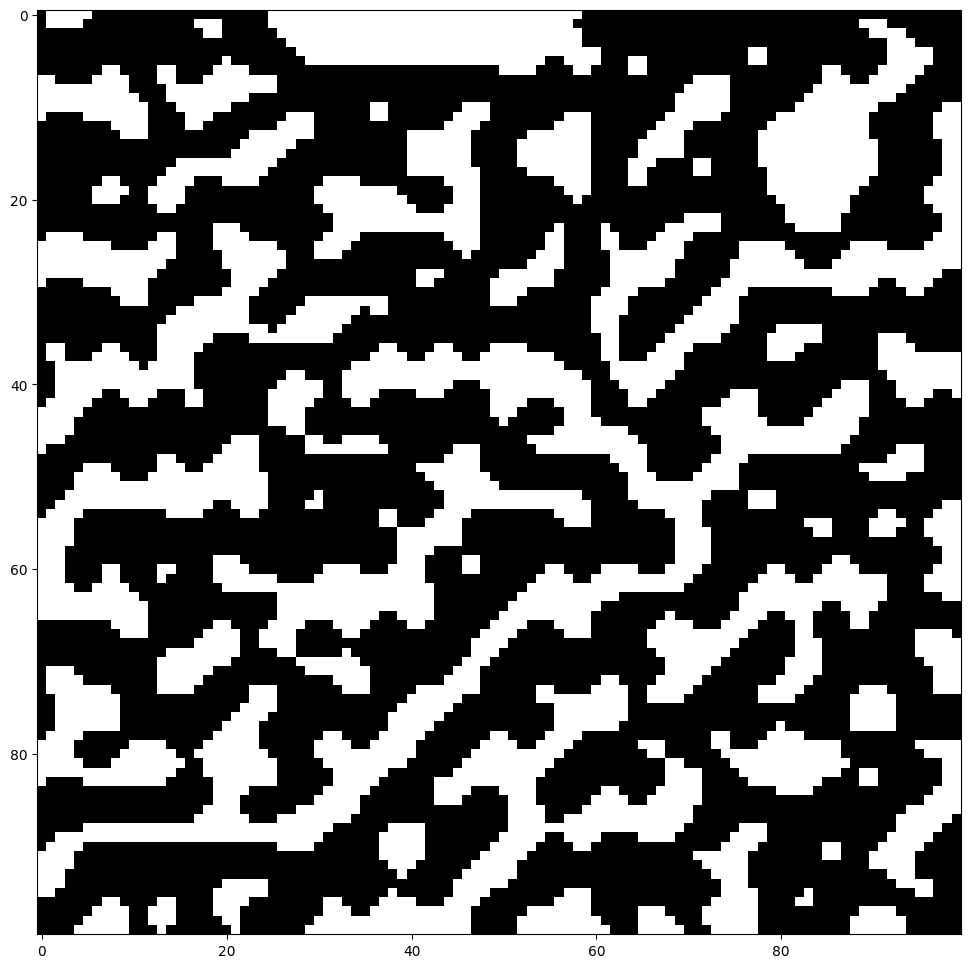

In [9]:
env = GridEnv(size=100)
env.sample_action()
env.plot_grid()

## Agent
- Take random action
- Note trajectory, current position, and visible patch at all times
- Agent can take random action
- Agent needs to add current poision to trajectory
- Agent state -> (4xgrid)
  - 0 for unknown
  - 1 for obstacle
  - 0.5 for explored part,
  - 2 for current position

In [10]:
class Agent():
    def __init__(self, size=100, visible_patch=3):
        self.trajectory = []
        self.position = np.array((0,0))
        self.visible_patch = np.zeros((visible_patch,visible_patch))
        self.grid = np.zeros((size, size))
        self.size = size
    
    def update_state(self, visible_patch, position):
        x,y = position
        visible_patch = (visible_patch + 1) * (0.5)
        for dx in range(-1, 2):  # This will loop through -1, 0, 1
            for dy in range(-1, 2):  # This will loop through -1, 0, 1
                nx, ny = x + dx, y + dy            
                if 0 <= nx < size and 0 <= ny < size:
                    self.grid[nx][ny] = visible_patch[1+dx,1+dy]
        self.trajectory.append(tuple(position))

        # TO ACCOMODATE FOR CURRENT POSITION, CAN ALSO SAVE AS NEXT POSITION
        state_grid = self.grid.copy()
        state_grid[x,y] = 2
        return state_grid

    def show_grid(self):
        plt.imshow(self.grid, cmap='grey')
        plt.show()

### Run agent for n random samples
Run the agent for 100,000 random samples and see how the agent behaves and how much area the agent explores

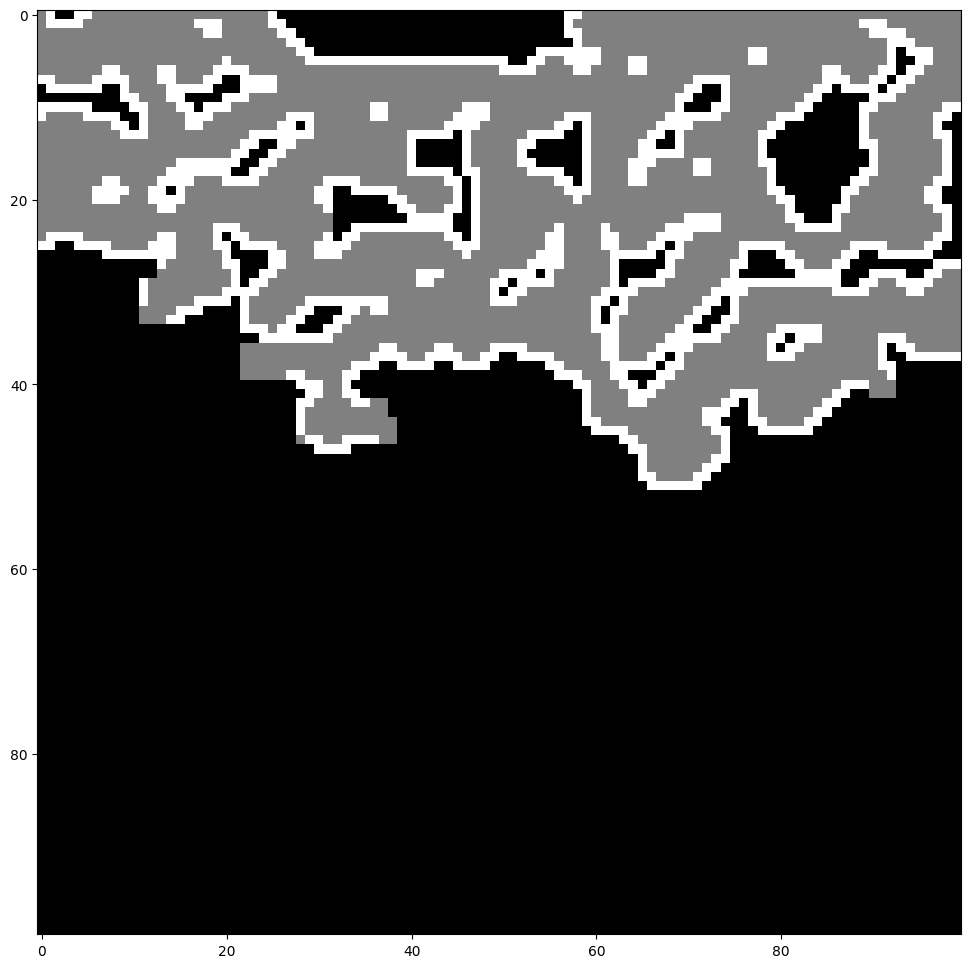

In [11]:
agent = Agent()
env.reset()

for i in range(100_000):
    action = env.sample_action()
    new_state, reward, done = env.step(action)

    new_pos, visible_patch = new_state
    agent.update_state(visible_patch, new_pos)
agent.show_grid()

## Actor Critic Learning
- Replay Buffer
- Sample actions from env
- Store in buffer of size
- Sample from buffer
- If train_freq
- - Train policy
- If target_freq
- - Train target network

In [12]:
class ReplayBuffer():
    def __init__(self, buffer_size=10_000):
        # STORE S,A,R,S`,D
        self.buffer = []
        self.buffer_size = buffer_size

    def initialize_buffer(self, env):
        state, done = env.reset()
        state_pos, state_patch = state
        state_grid = agent.update_state(state_patch, state_pos)
        action_keys = list(env.actions.keys())

        state = (state_grid, state_patch) # Add grid and visible patch to state.

        for i in range(self.buffer_size):
            action = env.sample_action()
            next_state, reward, done = env.step(action)
            action_key = action_keys.index(action)
            
            next_pos, next_patch = next_state
            next_state_grid = agent.update_state(next_patch, next_pos)
            next_state = (next_state_grid, next_patch)

            replay = (state, action_key, next_state, reward, done)
            self.buffer.append(replay)

            if done:
                state, done = env.reset()
                state = np.zeros_like(env.grid)
            state = next_state

    def add(self, item):
        if len(self.buffer) == self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append(item)

    def length(self):
        return len(self.buffer)

    def sample_batch(self, batch_size=32):
        batch = []
        idx = random.sample(range(0,self.buffer_size), batch_size)
        for i in idx:
            if i > len(self.buffer):
                print(i, len(self.buffer))
            batch.append(self.buffer[i])
        return batch

    def unwrap_batch(self, batch):
        states = []
        actions = []
        next_states = []
        rewards = []
        dones = []
        
        for item in batch:
            state, action, next_state, reward, done = item
            states.append(state)
            actions.append(action)
            next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
        return states, actions, rewards, next_states, dones

In [13]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

In [14]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(32 * 21 * 21, 128)  # After 3 pooling layers (100 -> 12)
        self.fc2 = nn.Linear(128, 4)  # Output 4 classes

        self.flatten = nn.Flatten()
        
        self.patch_fc1 = nn.Linear(9,32)
        self.patch_fc2 = nn.Linear(32,32)
        self.patch_fc3 = nn.Linear(32,4)        
        
    def forward(self, x):
        x1,x2 = x
        
        x1 = self.pool(torch.relu(self.conv1(x1)))
        x1 = self.pool(torch.relu(self.conv2(x1)))
        x1 = torch.relu(self.conv3(x1))
        x1 = self.flatten(x1)
        x1 = self.fc1(x1)
        x1 = self.fc2(x1)
        x1 = F.softmax(x1, dim=1)

        x2 = self.flatten(x2)
        x2 = self.patch_fc1(x2)
        x2 = self.patch_fc2(x2)
        x2 = self.patch_fc3(x2)
        x2 = F.sigmoid(x2)
        x = x1 * x2
        # x = x2
        return x

In [15]:
model = DQN()

grid_tensor = torch.from_numpy(grid).unsqueeze(0).unsqueeze(0)
state, done = env.reset()
patch = state[1]
patch = torch.from_numpy(patch).unsqueeze(0)

model((grid_tensor, patch))

tensor([[0.1178, 0.1373, 0.1361, 0.1237]], grad_fn=<MulBackward0>)

In [16]:
class DQNAgent():
    def __init__(self, params):
        # Set all params
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.params = params
        self.env = GridEnv()
        self.action_keys = list(self.env.actions.keys())

        self.behavior_net = DQN().to(self.device)
        self.target_net = DQN().to(self.device)
        self.target_net.load_state_dict(state_dict=self.behavior_net.state_dict())
        
        self.buffer = ReplayBuffer(buffer_size=self.params['replay_buffer_size'])
        self.buffer.initialize_buffer(self.env)
        self.opt_agent = torch.optim.AdamW(self.behavior_net.parameters(), lr=0.0005)
        self.losses = []
        self.episode_durations = []
        self.eps_rewards = []
        self.params['num_steps'] = 0
    
    def get_action(self, epsilon, state):
        if np.random.random() < epsilon:
            return self.env.sample_action()
        else:
            state_grid, state_patch = state
            state_grid = torch.from_numpy(state_grid).to(torch.float).to(self.device)
            state_grid = state_grid.unsqueeze(0).unsqueeze(0)
            
            state_patch = torch.from_numpy(state_patch).to(torch.float).to(self.device).unsqueeze(0)
            state = (state_grid, state_patch)
            with torch.no_grad():
                q_values = self.behavior_net(state)
                action = q_values.argmax(dim=1)[0].item()

            return self.action_keys[int(action)]

    def optimize_agent(self, states, actions, rewards, next_states, dones):

        states_grid, states_patch = [],[]
        for i in states:
            grid, patch = i
            states_grid.append(grid)
            states_patch.append(patch)

        states_grid = np.array(states_grid)
        states_grid = torch.tensor(states_grid, dtype=torch.float).to(self.device)
        states_grid = states_grid.unsqueeze(dim=1)
        
        states_patch = np.array(states_patch)
        states_patch = torch.tensor(states_patch, dtype=torch.float).to(self.device)
        states_patch = states_patch.unsqueeze(dim=1)
        states = (states_grid, states_patch)
        
        actions = torch.tensor(actions, dtype=torch.float).to(self.device)
        actions = actions.unsqueeze(dim=1)
    
        rewards = torch.tensor(rewards, dtype=torch.float).to(self.device)
        rewards = rewards.unsqueeze(dim=1)

        next_grid, next_patch = [],[]
        for i in next_states:
            grid, patch = i
            next_grid.append(grid)
            next_patch.append(patch)
        
        next_grid = np.array(next_grid)
        next_grid = torch.tensor(next_grid, dtype=torch.float).to(self.device)
        next_grid = next_grid.unsqueeze(dim=1)
        
        next_patch = np.array(next_patch)
        next_patch = torch.tensor(next_patch, dtype=torch.float).to(self.device)
        next_patch = next_patch.unsqueeze(dim=1)
        next_states = (next_grid, next_patch)
        
        dones = torch.tensor(dones, dtype=torch.float).to(self.device)
        dones = dones.unsqueeze(dim=1)
        
        q_values = self.behavior_net(next_states)
        with torch.no_grad():
            target_q_values = rewards + self.params['gamma'] * (1 - dones) * self.target_net(next_states)
    
        critic_loss = F.mse_loss(q_values, target_q_values)
        self.opt_agent.zero_grad()
        critic_loss.backward()
        self.opt_agent.step()

        return critic_loss.item()

    def optimize_target(self):
        self.target_net.load_state_dict(state_dict=self.behavior_net.state_dict())
        
    def train(self, num_steps):
        epsilon = self.params['epsilon']
        decay = self.params['decay']
        min_epsilon = self.params['min_epsilon']
        log_freq = self.params['log_freq']

        # RESET ENV
        state, done = env.reset()
        state_grid = np.zeros_like(env.grid)
        state_patch = state[1]
        state = (state_grid, state_patch)
        G = 0
        episode_length = 0
        
        for i in range(num_steps):

            action = self.get_action(epsilon, state)
            action_key = self.action_keys.index(action)

            next_state, reward, done = env.step(action)
            next_pos, next_patch = next_state
            next_grid = agent.update_state(next_patch, next_pos)
            next_state = (next_grid, next_patch)
            
            replay_item = (state, action_key, next_state, reward, done)    
            self.buffer.add(replay_item)
            G += reward
            
            if done:
                state, done = env.reset()
                state_grid = np.zeros_like(env.grid)
                state_patch = state[1]
                state = (state_grid, state_patch)
                
                self.eps_rewards.append(G)
                self.episode_durations.append(episode_length+1)
                G = 0                
                episode_length = 0

            else:
                episode_length+=1
                state = next_state

            epsilon = max(min_epsilon, epsilon*decay)            

            # IF TRAIN FREQ UPDATE AGENT
            if i % self.params['agent_frq'] == 0:
                batch = self.buffer.sample_batch(batch_size=self.params['batch_size'])
                states, actions, rewards, next_states, dones = self.buffer.unwrap_batch(batch)
                loss = self.optimize_agent(states, actions, rewards, next_states, dones)
                self.losses.append(loss)

            # IF TARGET_FREQ UPATE TARGET            
            if i % self.params['target_frq'] == 0:
                self.optimize_target()

            if (i+1)%log_freq == 0:
                print(f' Completed step = {i+1}, avg reward = {np.mean(self.eps_rewards)}, avg_length = {np.mean(self.episode_durations)}')

        return self.episode_durations, self.losses, self.eps_rewards


    def save(self):
        agent_name = self.params['agent_name']
        num_steps = self.params['num_steps']
        
        dir_name = os.path.join('saved_models', agent_name, str(num_steps))

        # Create nested directory if it doesn't exist
        os.makedirs(dir_name, exist_ok=True)

        # Save critic model
        qnet_path = os.path.join(dir_name, f"{agent_name}_qnet.pth")
        torch.save(self.behavior_net.state_dict(), qnet_path)

        # Save other info
        self.params['eps_rewards'] = self.eps_rewards
        self.params['episode_durations'] = self.episode_durations
        self.params['losses'] = self.losses

        params_path = os.path.join(dir_name, f"{agent_name}_params.json")
        with open(params_path, 'w') as f:
            json.dump(self.params, f)


    def load(self, num_steps):
        agent_name = self.params['agent_name']
        dir_name = os.path.join('saved_models', agent_name, str(num_steps))
        params_path = os.path.join(dir_name, f"{agent_name}_params.json")

        # Load params
        with open(params_path, 'r') as f:
            self.params = json.load(f)

        # Load critic model
        qnet_path = os.path.join(dir_name, f"{agent_name}_qnet.pth")
        self.target_net.load_state_dict(torch.load(qnet_path, weights_only=True))
        self.behavior_net.load_state_dict(torch.load(qnet_path, weights_only=True))

        # Restore tracking variables
        self.eps_rewards = self.params.get('eps_rewards', [])
        self.episode_durations = self.params.get('episode_durations', [])
        self.losses = self.params.get('losses', [])

In [ ]:
train_parameters = {
    'observation_dim': 2,
    'action_dim': 4,
    'gamma': 0.99,

    'epsilon':1,
    'decay':0.99,
    'min_epsilon':0.1,

    'replay_buffer_size': 50_000,
    'agent_frq': 4,
    'target_frq': 1_000,

    'batch_size': 256,
    'learning_rate': 1e-3,
    'agent_name': "dqn_v1",
    'agent_description' : 'With rewards -100, -10, +10',
    'log_freq' : 1_000,
}
dqn_agent = DQNAgent(train_parameters)

# eps_lengths, losses, rewards = dqn_agent.train(5_000)

 Completed step = 1000, avg reward = -105.70469798657719, avg_length = 6.704697986577181
 Completed step = 2000, avg reward = -105.84931506849315, avg_length = 6.8493150684931505
 Completed step = 3000, avg reward = -105.90092165898618, avg_length = 6.900921658986175
 Completed step = 4000, avg reward = -105.91349480968859, avg_length = 6.913494809688581
 Completed step = 5000, avg reward = -105.9196675900277, avg_length = 6.919667590027701


In [34]:
eps_lengths, losses, rewards = dqn_agent.train(50_000)

 Completed step = 1000, avg reward = -105.92301545018647, avg_length = 6.923015450186468
 Completed step = 2000, avg reward = -105.92051282051283, avg_length = 6.920512820512821
 Completed step = 3000, avg reward = -105.92355269668481, avg_length = 6.923552696684809
 Completed step = 4000, avg reward = -105.92758126195028, avg_length = 6.927581261950287
 Completed step = 5000, avg reward = -105.92974347122718, avg_length = 6.929743471227178
 Completed step = 6000, avg reward = -105.93266219239374, avg_length = 6.932662192393736
 Completed step = 7000, avg reward = -105.92980935875217, avg_length = 6.929809358752166
 Completed step = 8000, avg reward = -105.92692146157077, avg_length = 6.926921461570768
 Completed step = 9000, avg reward = -105.92563162184189, avg_length = 6.925631621841891
 Completed step = 10000, avg reward = -105.92616785431512, avg_length = 6.926167854315123
 Completed step = 11000, avg reward = -105.9274302213667, avg_length = 6.9274302213666985
 Completed step = 1

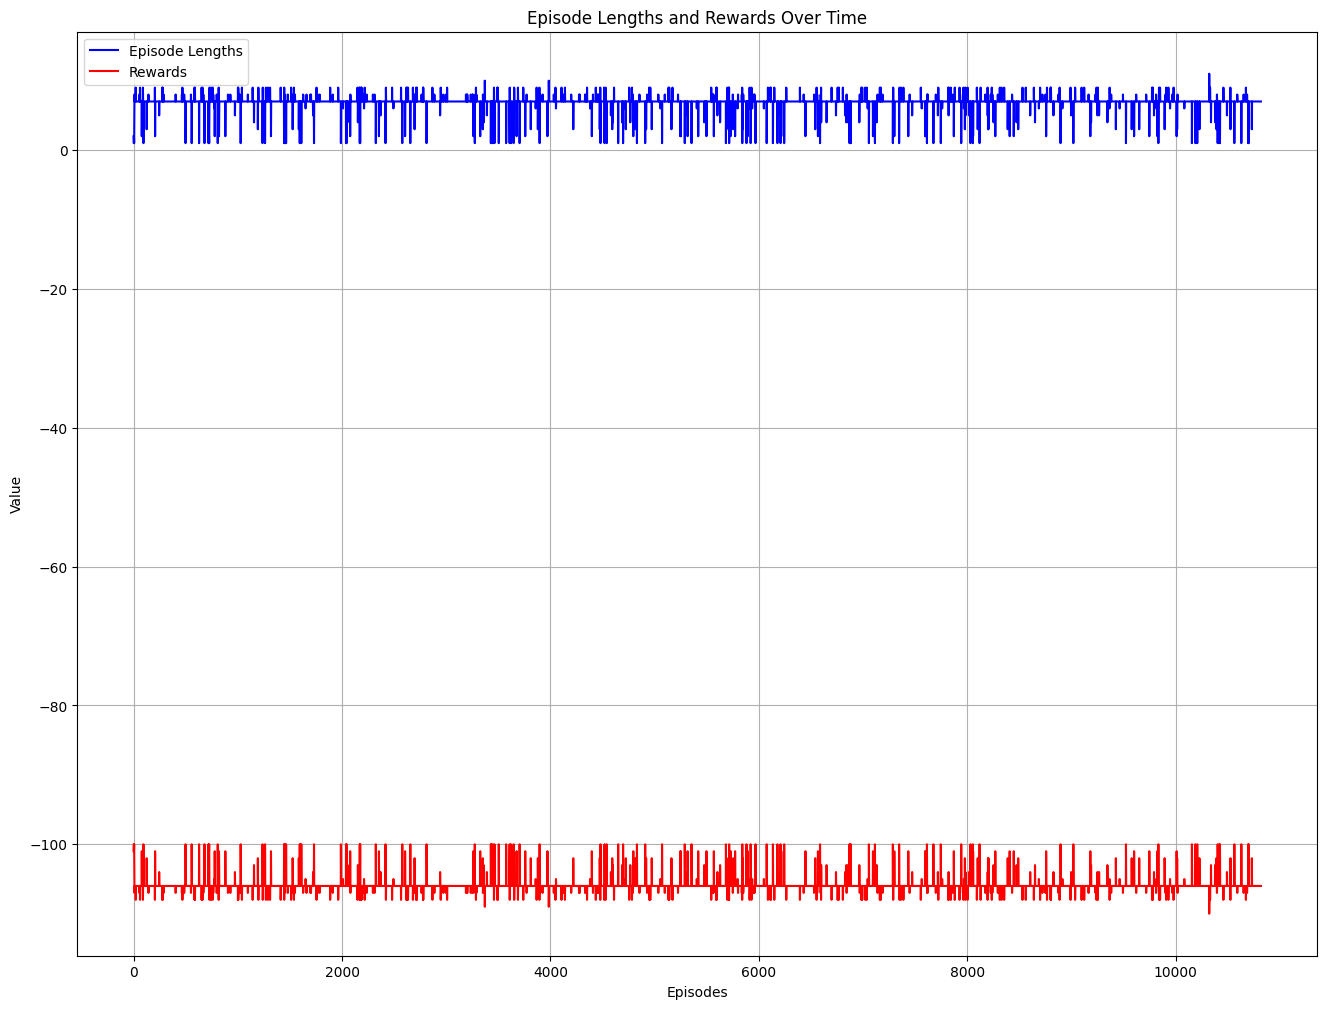

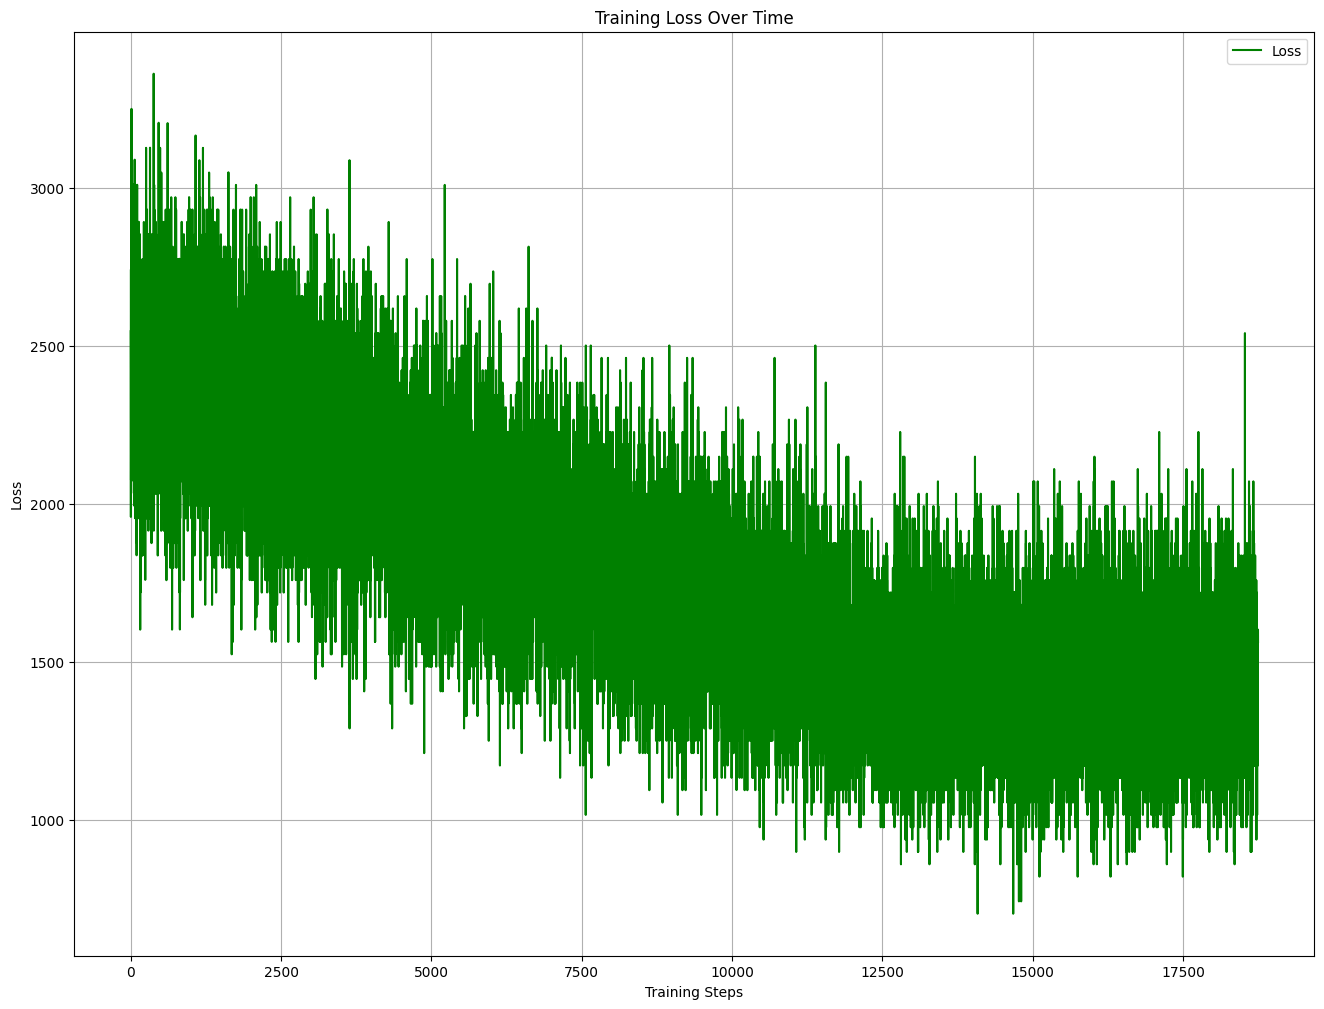

In [23]:
# First plot: Episode lengths and rewards
# plt.figure(figsize=(10, 5))
plt.plot(eps_lengths, c='b', label='Episode Lengths')
plt.plot(rewards, c='r', label='Rewards')
plt.title('Episode Lengths and Rewards Over Time')
plt.xlabel('Episodes')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Second plot: Losses
# plt.figure(figsize=(10, 5))
plt.plot(losses, c='g', label='Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Completed at step 6 with reward -100


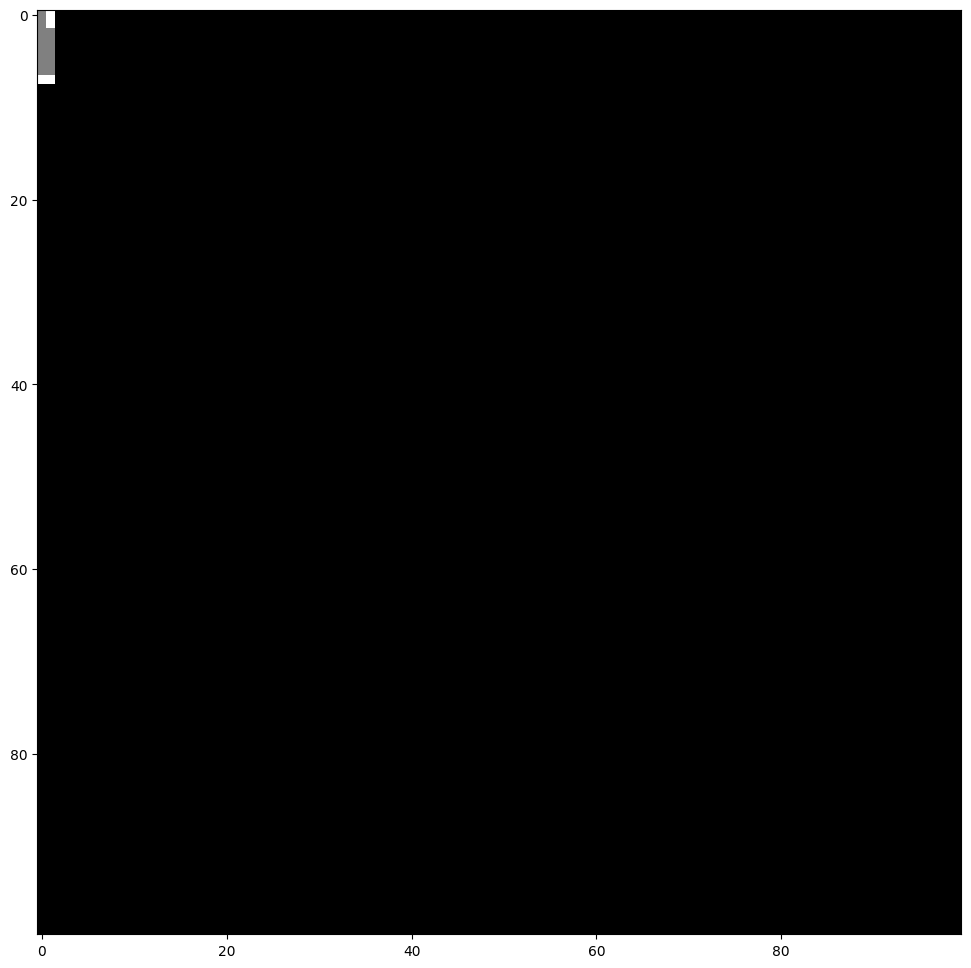

In [36]:
agent = Agent()
state, done = env.reset()
state_grid = np.zeros_like(env.grid)
state_patch = state[1]
state = (state_grid, state_patch)

for i in range(100_000):
    
    action = dqn_agent.get_action(epsilon=0.0, state=state)
    next_state, reward, done = env.step(action)
    next_pos, next_patch = next_state
    next_grid = agent.update_state(next_patch, next_pos)
    next_state = (next_grid, next_patch)

    if done:
        print(f'Completed at step {i} with reward {reward}')
        break
    state = next_state
agent.show_grid()

In [19]:
train_parameters = {
    'observation_dim': 2,
    'action_dim': 4,
    'gamma': 0.99,

    'epsilon':1,
    'decay':0.99,
    'min_epsilon':0.1,

    'replay_buffer_size': 50_000,
    'agent_frq': 4,
    'target_frq': 1_000,

    'batch_size': 256,
    'learning_rate': 1e-3,
    'agent_name': "dqn_v1",
    'agent_description' : 'With rewards -100, -10, +10',
    'log_freq' : 1_000,
}
dqn_agent = DQNAgent(train_parameters)
dqn_agent.load(0)

In [22]:
rewards = dqn_agent.params['eps_rewards']
eps_lengths = dqn_agent.params['episode_durations']
losses = dqn_agent.params['losses']